In [1]:
import pickle
import numpy as np
from nilearn import plotting, datasets
import networkx as nx
import os

In [5]:
with open("FCs_average.pkl", "rb") as f:
    fcs:dict = pickle.load(f)
atlas_labels = datasets.fetch_atlas_aal()['labels']

In [6]:
average_fc_preop = np.zeros((116, 116))
average_fc_postop = np.zeros((116, 116))
for sub in fcs:
    average_fc_preop += fcs[sub]["ses-preop"]
    average_fc_postop += fcs[sub]["ses-postop"]
average_fc_preop /= len(fcs)
average_fc_postop /= len(fcs)

In [7]:
# # 二值化
# fc[abs(fc) >= 0.5] = 1
# fc[abs(fc) < 0.5] = 0

# 创建图
fcg_preop = nx.Graph()
fcg_preop.add_edges_from([(atlas_labels[i], atlas_labels[j]) for i in range(average_fc_preop.shape[0]) for j in range(average_fc_preop.shape[1]) if i != j and average_fc_preop[i][j] >= 0.5])
fcg_postop = nx.Graph()
fcg_postop.add_edges_from([(atlas_labels[i], atlas_labels[j]) for i in range(average_fc_postop.shape[0]) for j in range(average_fc_postop.shape[1]) if i != j and average_fc_postop[i][j] >= 0.5])
fc_graph_theory= {}
fc_graph_theory["ses-preop"] = {}
fc_graph_theory["ses-postop"] = {}

In [47]:
# degree（度）
fc_graph_theory["ses-preop"]["degree"] = fcg_preop.degree
fc_graph_theory["ses-postop"]["degree"] = fcg_postop.degree
print(fc_graph_theory["ses-preop"]["degress"])
print(fc_graph_theory["ses-postop"]["degree"])

# k-core（k度核）
fc_graph_theory["ses-preop"]["main_core"] = nx.k_core(fcg_preop)
fc_graph_theory["ses-postop"]["main_core"] = nx.k_core(fcg_postop)
print(fc_graph_theory["ses-preop"]["main_core"])
print(fc_graph_theory["ses-postop"]["main_core"])

# # characteristic path length/average shortest path length（特征路径长度/平均最短路径长度）
# fc_graph_theory["ses-preop"]["char_path_len"] = nx.average_shortest_path_length(fcg_preop)
# fc_graph_theory["ses-postop"]["char_path_len"] = nx.average_shortest_path_length(fcg_postop)

In [48]:
# 中心性
# degree centrality（度中心性）
fc_graph_theory["ses-preop"]["degree_centrality"] = nx.degree_centrality(fcg_preop)
fc_graph_theory["ses-postop"]["degree_centrality"] = nx.degree_centrality(fcg_postop)
print(fc_graph_theory["ses-preop"]["degree_centrality"])
print(fc_graph_theory["ses-postop"]["degree_centrality"])

# closeness centrality（接近中心性）
fc_graph_theory["ses-preop"]["closeness_centrality"] = nx.closeness_centrality(fcg_preop)
fc_graph_theory["ses-postop"]["closeness_centrality"] = nx.closeness_centrality(fcg_postop)
print(fc_graph_theory["ses-preop"]["closeness_centrality"])
print(fc_graph_theory["ses-postop"]["closeness_centrality"])

# betweenness centrality（中介中心性）
fc_graph_theory["ses-preop"]["betweenness_centrality"] = nx.betweenness_centrality(fcg_preop)
fc_graph_theory["ses-postop"]["betweenness_centrality"] = nx.betweenness_centrality(fcg_postop)
print(fc_graph_theory["ses-preop"]["betweenness_centrality"])
print(fc_graph_theory["ses-postop"]["betweenness_centrality"])

# Eigenvector Centrality（特征向量中心性）
fc_graph_theory["ses-preop"]["eigenvector_centrality"] = nx.eigenvector_centrality(fcg_preop)
fc_graph_theory["ses-postop"]["eigenvector_centrality"] = nx.eigenvector_centrality(fcg_postop)
print(fc_graph_theory["ses-preop"]["eigenvector_centrality"])
print(fc_graph_theory["ses-postop"]["eigenvector_centrality"])

In [49]:
# 聚类性质
# numbers of triangles（三角形数）
fc_graph_theory["ses-preop"]["triangles"] = nx.triangles(fcg_preop)
fc_graph_theory["ses-postop"]["triangles"] = nx.triangles(fcg_postop)
print(fc_graph_theory["ses-preop"]["triangles"])
print(fc_graph_theory["ses-postop"]["triangles"])

# clustering efficiency（聚类系数）
fc_graph_theory["ses-preop"]["clustering"] = nx.clustering(fcg_preop)
fc_graph_theory["ses-postop"]["clustering"] = nx.clustering(fcg_postop)
print(fc_graph_theory["ses-preop"]["clustering"])
print(fc_graph_theory["ses-postop"]["clustering"])

# transitivity（传递性）
fc_graph_theory["ses-preop"]["transitivity"] = nx.transitivity(fcg_preop)
fc_graph_theory["ses-postop"]["transitivity"] = nx.transitivity(fcg_postop)
print(fc_graph_theory["ses-preop"]["transitivity"])
print(fc_graph_theory["ses-postop"]["transitivity"])

In [50]:
# 关联性
# Network Assortativity（网络关联性）
fc_graph_theory["ses-preop"]["degree_assortativity_coefficient"] = nx.degree_assortativity_coefficient(fcg_preop)
fc_graph_theory["ses-postop"]["degree_assortativity_coefficient"] = nx.degree_assortativity_coefficient(fcg_postop)
print(fc_graph_theory["ses-preop"]["degree_assortativity_coefficient"])
print(fc_graph_theory["ses-postop"]["degree_assortativity_coefficient"])

# average neighbor degree（平均邻居度）
fc_graph_theory["ses-preop"]["average_neighbor_degree"] = nx.average_neighbor_degree(fcg_preop)
fc_graph_theory["ses-postop"]["average_neighbor_degree"] = nx.average_neighbor_degree(fcg_postop)
print(fc_graph_theory["ses-preop"]["average_neighbor_degree"])
print(fc_graph_theory["ses-postop"]["average_neighbor_degree"])

# average degree connectivity（平均度连接）
fc_graph_theory["ses-preop"]["average_degree_connectivity"] = nx.average_degree_connectivity(fcg_preop)
fc_graph_theory["ses-postop"]["average_degree_connectivity"] = nx.average_degree_connectivity(fcg_postop)
print(fc_graph_theory["ses-preop"]["average_degree_connectivity"])
print(fc_graph_theory["ses-postop"]["average_degree_connectivity"])

In [51]:
# 效率性质
# global efficiency（全局效率）
fc_graph_theory["ses-preop"]["global_efficency"] = nx.global_efficiency(fcg_preop)
fc_graph_theory["ses-postop"]["global_efficency"] = nx.global_efficiency(fcg_postop)
print(fc_graph_theory["ses-preop"]["global_efficency"])
print(fc_graph_theory["ses-postop"]["global_efficency"])

# local efficiency（局部效率）
fc_graph_theory["ses-preop"]["local_efficency"] = nx.local_efficiency(fcg_preop)
fc_graph_theory["ses-postop"]["local_efficency"] = nx.local_efficiency(fcg_postop)
print(fc_graph_theory["ses-preop"]["local_efficency"])
print(fc_graph_theory["ses-postop"]["local_efficency"])

# ratio of local to global efficiency（局部全局效率比）
fc_graph_theory["ses-preop"]["ratio"] = fc_graph_theory["ses-preop"]["local_efficency"]/fc_graph_theory["ses-preop"]["global_efficency"]
fc_graph_theory["ses-postop"]["ratio"] = fc_graph_theory["ses-postop"]["local_efficency"]/fc_graph_theory["ses-postop"]["global_efficency"]
print(fc_graph_theory["ses-preop"]["ratio"])
print(fc_graph_theory["ses-postop"]["ratio"])

In [ ]:
# # rich club
# rich_club = nx.rich_club_coefficient(fcg)

# small-world coefficient（小世界系数）
fc_graph_theory["ses-preop"]["small_world"] = nx.sigma(fcg_preop, 30)
fc_graph_theory["ses-postop"]["small_world"] = nx.sigma(fcg_postop, 30)
print(fc_graph_theory["ses-preop"]["small_world"])
print(fc_graph_theory["ses-postop"]["small_world"])

In [ ]:
save_path = "graph_theory"
os.makedirs(save_path, exist_ok=True)
with open(f"{save_path}/average_total.pkl", "wb") as f:
    pickle.dump(fc_graph_theory, f)

In [78]:
for index in fc_graph_theory["ses-postop"]:
    print(index, fc_graph_theory["ses-preop"][index])
    print(index, fc_graph_theory["ses-postop"][index])

degree [('Precentral_L', 28), ('Precentral_R', 34), ('Frontal_Sup_L', 29), ('Frontal_Sup_R', 33), ('Frontal_Mid_L', 23), ('Frontal_Mid_R', 28), ('Frontal_Inf_Oper_L', 13), ('Frontal_Inf_Tri_L', 17), ('Rolandic_Oper_L', 15), ('Supp_Motor_Area_L', 36), ('Supp_Motor_Area_R', 36), ('Frontal_Sup_Medial_L', 16), ('Insula_L', 29), ('Cingulum_Mid_L', 43), ('Cingulum_Mid_R', 54), ('Occipital_Sup_L', 26), ('Occipital_Mid_L', 26), ('Postcentral_L', 36), ('Postcentral_R', 37), ('Parietal_Sup_L', 37), ('Parietal_Sup_R', 37), ('Parietal_Inf_L', 30), ('SupraMarginal_L', 25), ('Precuneus_L', 49), ('Precuneus_R', 53), ('Paracentral_Lobule_L', 26), ('Paracentral_Lobule_R', 27), ('Temporal_Sup_L', 41), ('Temporal_Mid_L', 55), ('Frontal_Inf_Oper_R', 25), ('Frontal_Inf_Tri_R', 22), ('Rolandic_Oper_R', 33), ('Frontal_Sup_Medial_R', 20), ('Insula_R', 34), ('Cingulum_Ant_R', 25), ('Calcarine_R', 46), ('Cuneus_L', 38), ('Cuneus_R', 46), ('Lingual_R', 53), ('Occipital_Sup_R', 34), ('Occipital_Mid_R', 33), ('Par

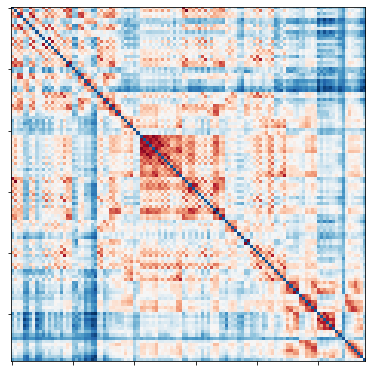

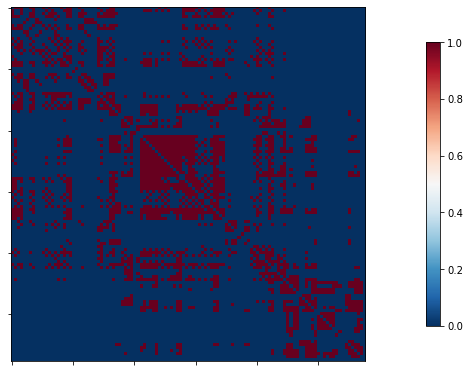

In [74]:
plotting.plot_matrix(average_fc_preop, colorbar=False)
plotting.plot_matrix(abs(average_fc_preop) > 0.5, colorbar=False)

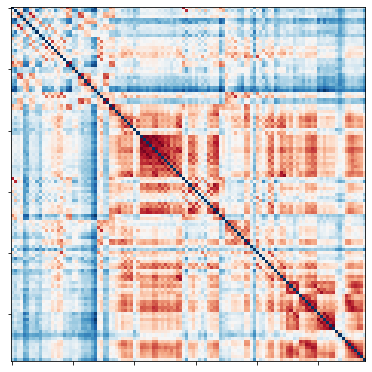

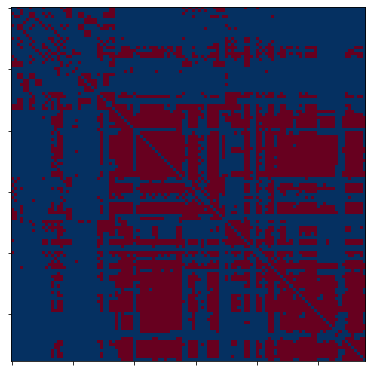

In [76]:
plotting.plot_matrix(average_fc_postop, colorbar=False)
plotting.plot_matrix(abs(average_fc_postop) > 0.5, colorbar=False)

In [81]:
atlas = datasets.fetch_atlas_aal()
atlas_labels = atlas['labels']
coords = plotting.find_parcellation_cut_coords(atlas["maps"])

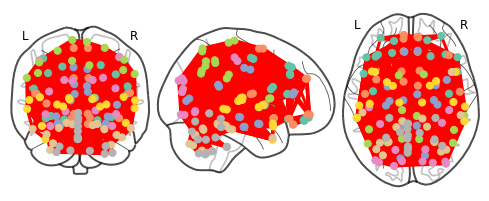

In [84]:
plotting.plot_connectome((abs(average_fc_preop) > 0.5).astype(int), coords, colorbar=False)